# Módulo 4 - Big Data

Código base por: Juan Esquivel

# Entrenamiento de modelos

Dedicaremos esta lección para el desarrollo de un ejemplo de entrenamiento de un modelo básico, de principio a fin, en Apache Spark. Iniciaremos desde la lectura de los datos, limpieza de los mismos, análisis descriptivo, almacenamiento intermedio y entrenamiento de un modelo de regresión.

Para esta actividad utilizaremos un conjunto de datos relacionado con la predicción del precio de viviendas, que se puede descargar desde https://www.kaggle.com/harlfoxem/housesalesprediction

# Lectura y limpieza
Como hemos visto en módulos anteriores, una de las tareas más comunes al procesar datos es el ajuste y limpieza de los datos. Este ejemplo refleja esta situación. En las celdas siguientes leeremos los datos de un archivo CSV y realizaremos diferentes pasos para poder cargar los datos a una tabla en PostgreSQL que almacenará el conjunto de datos en su forma deseada para abordar el análisis.

In [1]:
import findspark
findspark.init()

import pyspark

from pyspark.sql import SparkSession


In [2]:
from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                               DecimalType, StructField, StructType)

spark = SparkSession \
    .builder \
    .appName("Basic JDBC pipeline") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

houses_df = spark \
    .read \
    .format("csv") \
    .option("path", "kc_house_data.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("id", StringType()),
                StructField("date", StringType()),
                StructField("price", StringType()),
                StructField("bedrooms", IntegerType()),
                StructField("bathrooms", FloatType()),
                StructField("sqft_living", IntegerType()),
                StructField("sqft_lot", IntegerType()),
                StructField("floors", StringType()),
                StructField("waterfront", IntegerType()),
                StructField("view", IntegerType()),
                StructField("condition", IntegerType()),
                StructField("grade", IntegerType()),
                StructField("sqft_above", IntegerType()),
                StructField("sqft_basement", IntegerType()),
                StructField("yr_built", IntegerType()),
                StructField("yr_renovated", IntegerType()),
                StructField("zipcode", StringType()),
                StructField("lat", FloatType()),
                StructField("long", FloatType()),
                StructField("sqft_living15", IntegerType()),
                StructField("sqft_lot15", IntegerType())])) \
    .load()


In [3]:
houses_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: integer (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- sqft_living15: integer (nullable = true)
 |-- sqft_lot15: integer (nullable = true)



In [4]:
houses_df.show()

+----------+---------------+----------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|        id|           date|     price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|yr_renovated|zipcode|    lat|    long|sqft_living15|sqft_lot15|
+----------+---------------+----------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+------------+-------+-------+--------+-------------+----------+
|7129300520|20141013T000000|    221900|       3|      1.0|       1180|    5650|     1|         0|   0|        3|    7|      1180|            0|    1955|           0|  98178|47.5112|-122.257|         1340|      5650|
|6414100192|20141209T000000|    538000|       3|     2.25|       2570|    7242|     2|         0|   0|        3|    7|      2170|       

In [5]:
houses_df.summary().show()

+-------+--------------------+---------------+------------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+------------------+
|summary|                  id|           date|             price|         bedrooms|         bathrooms|       sqft_living|          sqft_lot|            floors|          waterfront|               view|         condition|             grade|        sqft_above|     sqft_basement|          yr_built|      yr_renovated|           zipcode|                lat|               long|    sqft_living15|        sqft_lot15|
+-------+--------------------+---------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------

In [6]:
# Seleccionar un subconjunto de las columnas de interés y el objectivo que es el precio
columns_kept = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                'floors', 'condition', 'yr_built', 'price']
selected_columns_df = houses_df.select(columns_kept)

selected_columns_df.show()

+--------+---------+-----------+--------+------+---------+--------+----------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|condition|yr_built|     price|
+--------+---------+-----------+--------+------+---------+--------+----------+
|       3|      1.0|       1180|    5650|     1|        3|    1955|    221900|
|       3|     2.25|       2570|    7242|     2|        3|    1951|    538000|
|       2|      1.0|        770|   10000|     1|        3|    1933|    180000|
|       4|      3.0|       1960|    5000|     1|        5|    1965|    604000|
|       3|      2.0|       1680|    8080|     1|        3|    1987|    510000|
|       4|      4.5|       5420|  101930|     1|        3|    2001|1.225e+006|
|       3|     2.25|       1715|    6819|     2|        3|    1995|    257500|
|       3|      1.5|       1060|    9711|     1|        3|    1963|    291850|
|       3|      1.0|       1780|    7470|     1|        3|    1960|    229500|
|       3|      2.5|       1890|    6560|     2|    

In [7]:
# La cantidad de pisos y el precio fueron cargados como string. Deben ajustarse.
correct_types_df = selected_columns_df \
    .withColumn('floors', selected_columns_df['floors'].cast(FloatType())) \
    .withColumn('price', selected_columns_df['price'].cast(DecimalType()))

correct_types_df.show()

+--------+---------+-----------+--------+------+---------+--------+-------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|condition|yr_built|  price|
+--------+---------+-----------+--------+------+---------+--------+-------+
|       3|      1.0|       1180|    5650|   1.0|        3|    1955| 221900|
|       3|     2.25|       2570|    7242|   2.0|        3|    1951| 538000|
|       2|      1.0|        770|   10000|   1.0|        3|    1933| 180000|
|       4|      3.0|       1960|    5000|   1.0|        5|    1965| 604000|
|       3|      2.0|       1680|    8080|   1.0|        3|    1987| 510000|
|       4|      4.5|       5420|  101930|   1.0|        3|    2001|1225000|
|       3|     2.25|       1715|    6819|   2.0|        3|    1995| 257500|
|       3|      1.5|       1060|    9711|   1.0|        3|    1963| 291850|
|       3|      1.0|       1780|    7470|   1.0|        3|    1960| 229500|
|       3|      2.5|       1890|    6560|   2.0|        3|    2003| 323000|
|       3|  

In [8]:
# Almacenar el conjunto de datos limpio en la base de datos

correct_types_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "houses") \
    .save()

# Inspección de datos
Previo a entrenar el modelo es común que se realice algún tipo de descripción de los datos, para tener una idea del tipo de problema con el que nos enfrentamos. A continuación, algunas operacions útiles que podemos usar.


In [9]:
# Cargar el conjunto de datos. Esta vez desde la base de datos

# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://host.docker.internal:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "houses") \
    .load()
df.show()

+--------+---------+-----------+--------+------+---------+--------+-------+
|bedrooms|bathrooms|sqft_living|sqft_lot|floors|condition|yr_built|  price|
+--------+---------+-----------+--------+------+---------+--------+-------+
|       3|      1.0|       1180|    5650|   1.0|        3|    1955| 221900|
|       3|     2.25|       2570|    7242|   2.0|        3|    1951| 538000|
|       2|      1.0|        770|   10000|   1.0|        3|    1933| 180000|
|       4|      3.0|       1960|    5000|   1.0|        5|    1965| 604000|
|       3|      2.0|       1680|    8080|   1.0|        3|    1987| 510000|
|       4|      4.5|       5420|  101930|   1.0|        3|    2001|1225000|
|       3|     2.25|       1715|    6819|   2.0|        3|    1995| 257500|
|       3|      1.5|       1060|    9711|   1.0|        3|    1963| 291850|
|       3|      1.0|       1780|    7470|   1.0|        3|    1960| 229500|
|       3|      2.5|       1890|    6560|   2.0|        3|    2003| 323000|
|       3|  

In [10]:
# Información descriptiva del dataframe.
df.describe(['bedrooms', 'floors', 'yr_built']).show()

+-------+-----------------+------------------+------------------+
|summary|         bedrooms|            floors|          yr_built|
+-------+-----------------+------------------+------------------+
|  count|            21613|             21613|             21613|
|   mean| 3.37084162309721|1.4943089807060566|1971.0051357978994|
| stddev|0.930061831147451|0.5399888951423489|29.373410802386243|
|    min|                0|               1.0|              1900|
|    max|               33|               3.5|              2015|
+-------+-----------------+------------------+------------------+



In [11]:
# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
               'floors', 'condition', 'yr_built'],
    outputCol='features')

vector_df = assembler.transform(df)
vector_df = vector_df.select(['features', 'price'])
vector_df.show()


+--------------------+-------+
|            features|  price|
+--------------------+-------+
|[3.0,1.0,1180.0,5...| 221900|
|[3.0,2.25,2570.0,...| 538000|
|[2.0,1.0,770.0,10...| 180000|
|[4.0,3.0,1960.0,5...| 604000|
|[3.0,2.0,1680.0,8...| 510000|
|[4.0,4.5,5420.0,1...|1225000|
|[3.0,2.25,1715.0,...| 257500|
|[3.0,1.5,1060.0,9...| 291850|
|[3.0,1.0,1780.0,7...| 229500|
|[3.0,2.5,1890.0,6...| 323000|
|[3.0,2.5,3560.0,9...| 662500|
|[2.0,1.0,1160.0,6...| 468000|
|[3.0,1.0,1430.0,1...| 310000|
|[3.0,1.75,1370.0,...| 400000|
|[5.0,2.0,1810.0,4...| 530000|
|[4.0,3.0,2950.0,5...| 650000|
|[3.0,2.0,1890.0,1...| 395000|
|[4.0,1.0,1600.0,4...| 485000|
|[2.0,1.0,1200.0,9...| 189000|
|[3.0,1.0,1250.0,9...| 230000|
+--------------------+-------+
only showing top 20 rows



<AxesSubplot:>

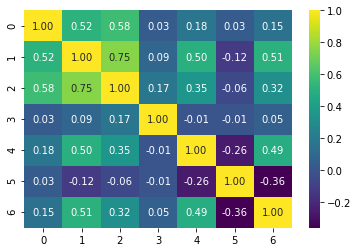

In [12]:
# Con la representación de vectores podemos calcular correlaciones
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt

pearson_matrix = Correlation.corr(vector_df, 'features').collect()[0][0]

sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='viridis')

# Estandarización
Como recordamos de los módulos anteriores es deseable que los datos se encuentren estandarizados o normalizados, para evitar que la magnitud de ciertos atributos dominen el proceso de entrenamiento. El módulo `pyspark.ml.feature` tiene varias alternativas. A continuación se presenta una.

In [13]:
from pyspark.ml.feature import StandardScaler

standard_scaler = StandardScaler(inputCol='features', outputCol='scaled')
scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)
scaled_df.show()

+--------------------+-------+--------------------+
|            features|  price|              scaled|
+--------------------+-------+--------------------+
|[3.0,1.0,1180.0,5...| 221900|[3.22559199779093...|
|[3.0,2.25,2570.0,...| 538000|[3.22559199779093...|
|[2.0,1.0,770.0,10...| 180000|[2.15039466519395...|
|[4.0,3.0,1960.0,5...| 604000|[4.30078933038790...|
|[3.0,2.0,1680.0,8...| 510000|[3.22559199779093...|
|[4.0,4.5,5420.0,1...|1225000|[4.30078933038790...|
|[3.0,2.25,1715.0,...| 257500|[3.22559199779093...|
|[3.0,1.5,1060.0,9...| 291850|[3.22559199779093...|
|[3.0,1.0,1780.0,7...| 229500|[3.22559199779093...|
|[3.0,2.5,1890.0,6...| 323000|[3.22559199779093...|
|[3.0,2.5,3560.0,9...| 662500|[3.22559199779093...|
|[2.0,1.0,1160.0,6...| 468000|[2.15039466519395...|
|[3.0,1.0,1430.0,1...| 310000|[3.22559199779093...|
|[3.0,1.75,1370.0,...| 400000|[3.22559199779093...|
|[5.0,2.0,1810.0,4...| 530000|[5.37598666298488...|
|[4.0,3.0,2950.0,5...| 650000|[4.30078933038790...|
|[3.0,2.0,18

# Regresión lineal
Como ejemplo de un tipo de modelo a entrenar usaremos una regresión lineal básica para tratar de predecir el precio. Para ellos utilizaremos los datos estandarizados.

In [14]:
# Nótese que no se hace partición de datos de entrenamiento (ejercicio posterior).
from pyspark.ml.regression import LinearRegression

regression = LinearRegression(featuresCol='scaled', labelCol='price')
regression_model = regression.fit(scaled_df)

print('Pesos: {}\n b: {}'.format(regression_model.coefficients, regression_model.intercept))

print('RMSE: {} r2: {}'.format(
    regression_model.summary.rootMeanSquaredError,
    regression_model.summary.r2))

scaled_df.describe().show()

# Si se quiere hacer predicciones nada más se requiere llamar a regression_model.transform(df)
# Esto regresa el dataset con una columna nueva

Pesos: [-64395.47318687582,50862.92091861797,278511.11197487527,-12339.081074522004,30946.977799688528,11683.836709724465,-94825.53343750679]
 b: 6223698.139208419
RMSE: 244323.53190293963 r2: 0.5570878698871067
+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             21613|
|   mean|       540088.1418|
| stddev|367127.19648270035|
|    min|             75000|
|    max|           7700000|
+-------+------------------+

